In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

Denver, Colorado 
Land Area = 401.36 km^2 / 154.97 mi^2 
population 2020 census = 715,522 
population estimate 2021 = 711,463 

In [3]:
raw_us_cases = pd.read_csv("data/RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("data/mask-use-by-county.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

In [4]:
raw_denver_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Colorado") & (raw_us_cases["Admin2"] == "Denver")]
#first 12 columns are general info about the state
denver_general_info = raw_denver_cases[raw_denver_cases.columns[0:12]]
#this is useful later
DENVER_FIPS = denver_general_info["FIPS"].values[0]
#lets take all the columns with deaths by date and pivot the table + make the date its own column. Schema of date, deaths
denver_cases_by_date =  raw_denver_cases[raw_denver_cases.columns[12:]]
denver_cases_by_date = pd.DataFrame(denver_cases_by_date.iloc[0])
denver_cases_by_date = denver_cases_by_date.reset_index()
denver_cases_by_date.columns = ["date", "cases"]
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
denver_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == DENVER_FIPS]
denver_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "CO") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Denver County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
denver_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = denver_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")


C:\Users\shurygin\AppData\Local\Temp\ipykernel_26560\1846355585.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denver_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = denver_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")


In [5]:
denver_cases_by_date

,date,cases
0,1/23/20,0
1,1/24/20,0
2,1/25/20,0
3,1/26/20,0
4,1/27/20,0
...,...,...
1006,10/25/22,212900
1007,10/26/22,213017
1008,10/27/22,213118
1009,10/28/22,213118


In [6]:
denver_cases_by_date["date"] = pd.to_datetime(denver_cases_by_date["date"])
denver_cases_by_date["7_average"] = denver_cases_by_date["cases"].rolling(7).mean()
denver_cases_by_date["case_rate"] = pd.Series(np.gradient(denver_cases_by_date["7_average"]), denver_cases_by_date["date"], name='case_rate').values
denver_mask_mandates_april_2020_aug_2021["date"] = pd.to_datetime(denver_mask_mandates_april_2020_aug_2021["date"])

C:\Users\shurygin\AppData\Local\Temp\ipykernel_26560\1342224909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denver_mask_mandates_april_2020_aug_2021["date"] = pd.to_datetime(denver_mask_mandates_april_2020_aug_2021["date"])


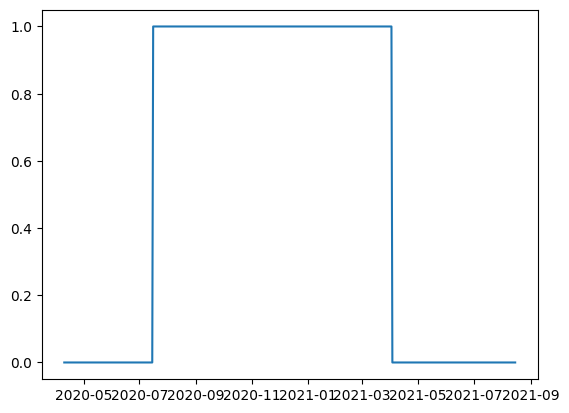

2020-07-16 00:00:00 2021-04-02 00:00:00


In [7]:
denver_deaths_by_date_with_mask_info = pd.merge(left=denver_cases_by_date, right=denver_mask_mandates_april_2020_aug_2021, on="date")
denver_deaths_by_date_with_mask_info["masks"] = (denver_deaths_by_date_with_mask_info["Face_Masks_Required_in_Public"] == "Yes").astype(int) #lets make this a 0 1 column
mask_mandate_start_date = min(denver_deaths_by_date_with_mask_info[denver_deaths_by_date_with_mask_info["masks"] == 1]["date"]) #for the case of colorado we only have 1 block of mask mandates
mask_mandate_end_date = max(denver_deaths_by_date_with_mask_info[denver_deaths_by_date_with_mask_info["masks"] == 1]["date"])
#proof that colorado only had 1 block of mask mandates, making shading really easy
plt.plot(denver_deaths_by_date_with_mask_info["date"], denver_deaths_by_date_with_mask_info["masks"])
plt.show()
print(mask_mandate_start_date, mask_mandate_end_date)

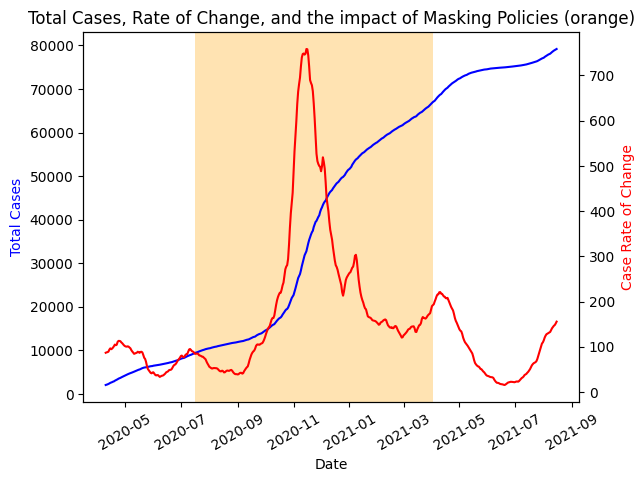

In [89]:
# you should create a time series showing the changes in the derivative function of the rate of infection.
# Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant.
#quick plot of deaths
fig, ax1 = plt.subplots()
plt.xticks(rotation = 30)
ax2 = ax1.twinx()
ax1.plot(denver_deaths_by_date_with_mask_info["date"], denver_deaths_by_date_with_mask_info["cases"], 'b-')
#keep in mind case rate is based on the 7 day average of cases in order to reduce crazy derivatives when centers are closed for weekends.
ax2.plot(denver_deaths_by_date_with_mask_info["date"], denver_deaths_by_date_with_mask_info["case_rate"], 'r-')
ax1.axvspan(mask_mandate_start_date, mask_mandate_end_date, color='orange', alpha=0.3, lw=0) #masking period
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color='b')
ax2.set_ylabel('Case Rate of Change', color='r')
ax1.set_title("Total Cases, Rate of Change, and the impact of Masking Policies (orange)")
#plt.savefig("figures/cases_and_masking_viz.png",  bbox_inches = "tight") #uncomment for saving the image.
plt.show()
